In [2]:
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn import *
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)  # suppresses general user warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # suppresses future deprecation warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)  # suppresses pandas performance warnings

df = pd.read_csv("../treedata.csv")
df = df.drop(columns=["ObjectID", "Other.1", "Length of Failed Part", "Diameter of Failed Part"], axis=1)
df = df.fillna("None")

categorical_cols = [ # have comma separated categorical values
    "Tree Species", "Condition", "Site Factors", "Type of Soil", "Weather factors",
    "Failed Part", "Root Failure", "Stem Failure", "Branch Failure",
    "Location and Percentage of Decay", "Decay Present"
]

from collections import defaultdict
all_unique_labels = defaultdict(set)

# extract all unique labels per column
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].apply(lambda x: [item.strip() for item in x.split(",") if item.strip() != ""])
    for items in df[col]:
        all_unique_labels[col].update(items)

for col in categorical_cols:
    for label in all_unique_labels[col]:
        df[f"{col}_{label}"] = df[col].apply(lambda x: int(label in x))

df = df.drop(columns=categorical_cols)

Root Failure Model Accuracy: 80.13%
Stem Failure Model Accuracy: 68.87%
Branch Failure Model Accuracy: 75.50%


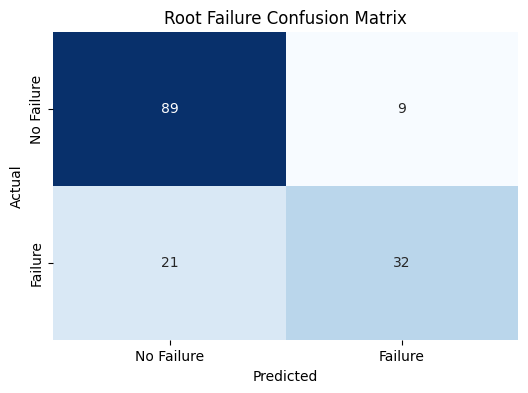

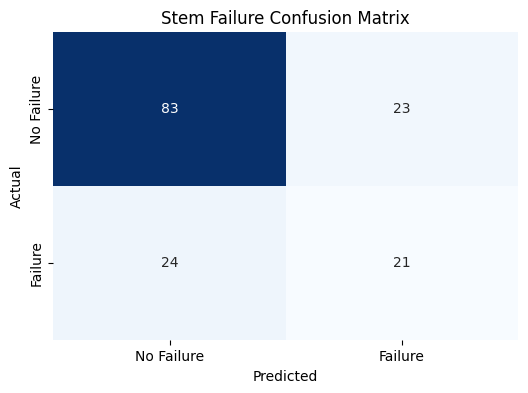

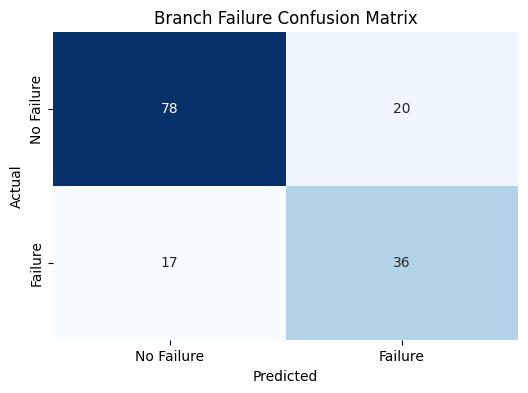

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

X = df.drop(columns=["Failed Part_BranchFailure", "Failed Part_RootFailure", "Failed Part_StemFailure", "Root Failure_None", "Stem Failure_None", "Branch Failure_None"])

def train_knn_model(X, y, n_neighbors=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create pipeline with MinMaxScaler and KNN
    pipeline = Pipeline([
        ("scaler", MinMaxScaler()),  # scales 0–1 for continuous features; leaves binary alone
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred, y_test

y_root = df['Failed Part_RootFailure']
accuracy_root, y_pred_root, y_test_root = train_knn_model(X, y_root)

y_stem = df['Failed Part_StemFailure']
accuracy_stem, y_pred_stem, y_test_stem = train_knn_model(X, y_stem)

y_branch = df['Failed Part_BranchFailure']
accuracy_branch, y_pred_branch, y_test_branch = train_knn_model(X, y_branch)

print(f"Root Failure Model Accuracy: {accuracy_root * 100:.2f}%")
print(f"Stem Failure Model Accuracy: {accuracy_stem * 100:.2f}%")
print(f"Branch Failure Model Accuracy: {accuracy_branch * 100:.2f}%")

# display the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test_root, y_pred_root), "Root Failure Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test_stem, y_pred_stem), "Stem Failure Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test_branch, y_pred_branch), "Branch Failure Confusion Matrix")